## Setup (rodar antes de tudo)

### Download

In [151]:
# For reading stock data from yahoo
import yfinance as yf
import pandas as pd
import datetime as dt
import time
# For time stamps
from datetime import datetime
def download_1():
    # The tech stocks we'll use for this analysis
    tech_list = ['AAPL',]

    for stock in tech_list:
        print(stock)
        globals()[stock] = yf.download(stock, end="2024-01-01")

    company_list = [globals()[stock] for stock in tech_list]

    return company_list

def download_2():
    # For reading stock data from yahoo
    # The tech stocks we'll use for this analysis
    tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN','TSLA','NVDA','META','AMD','BABA','INTC','PYPL','EA']

    # Set up End and Start times for data grab
    #end = datetime.now()
    #start = datetime(end.year - 5, end.month, end.day)

    for stock in tech_list:
        print(stock)
        globals()[stock] = yf.download(stock, start="2024-01-01")

    company_list = [globals()[stock] for stock in tech_list]
    company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON","TESLA","NVIDIA","META","AMD","ALIBABA","INTEL","PAYPAL","ELECTRONIC ARTS"]

    for company, com_name in zip(company_list, company_name):
        company["company_name"] = com_name
    
    return company_list

def download_3():
        # The tech stocks we'll use for this analysis
    tech_list = ['AAPL',]

    for stock in tech_list:
        print(stock)
        globals()[stock] = yf.download(stock, start="2024-01-01")

    company_list = [globals()[stock] for stock in tech_list]

    return company_list



### Tratamento

In [152]:
import os
import pathlib
def dataset_1():
    df = download_1()
    df = pd.concat(df, axis=0)
    df.reset_index(inplace=True)
    column_order = [
    'Date','Close',
    ]

    df = df[column_order].dropna()
    print(df.info())
    df.set_index('Date', drop=True, inplace=True)

    print(df.drop_duplicates().head())

    current_file_path = pathlib.Path().resolve()
    print(f"Current file path: {current_file_path}")

    # Save the DataFrame to a CSV file in the same directory
    stocks_path = current_file_path / 'data/train_data.csv'
    df.to_csv(stocks_path)

def dataset_2():
    #################################################################
    # TRATAMENTO DOS DADOS BAIXADOS E SALVAMENTO DOS DADOS TRATADOS #
    #################################################################

    import pandas as pd
    company_list = download_2()

    close = 'Adj Close'

    df = pd.concat(company_list, axis=0)
    df.reset_index(inplace=True)
    df.sort_values(by=['company_name','Date'])
    df['Will Increase'] = df.groupby('company_name')[close].shift(-1) > df.groupby('company_name')[close].shift(0)
    df['close_variation'] = df.groupby('company_name')[close].shift(0) - df.groupby('company_name')[close].shift(1)
    df['close_variation%'] = df.groupby('company_name')[close].shift(0) / df.groupby('company_name')[close].shift(1)

    def calculate_days_since(df):
        last_increase = 0
        last_decrease = 0
        days_since_increase = []
        days_since_decrease = []
        for will_increase in df['Will Increase']:
            days_since_increase.append(last_increase)
            days_since_decrease.append(last_decrease)
            if will_increase:
                last_increase = 0
                last_decrease += 1
            else:
                last_increase += 1
                last_decrease = 0
        return days_since_increase, days_since_decrease


    for company, group in df.groupby('company_name'):
        days_since_increase, days_since_decrease = calculate_days_since(group)
        df.loc[group.index, 'days_since_last_increase'] = days_since_increase
        df.loc[group.index, 'days_since_last_decrease'] = days_since_decrease

    if 'Date' in df.columns:
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        df['Day of the Week'] = df['Date'].dt.dayofweek

    column_order = [
        'Date','Month','Day', 'Day of the Week', 'Open', 'High', 'Low', 'Close',
        'Adj Close', 'Volume', 'company_name', 'Will Increase', 'close_variation',
        'close_variation%', 'days_since_last_increase', 'days_since_last_decrease'
    ]

    df = df[column_order].dropna()
    print(df.info())
    #print(df.drop_duplicates().info())
    print(df.sort_values(by=['company_name',"Date"]).head(15))
    current_file_path = pathlib.Path().resolve()
    print(f"Current file path: {current_file_path}")

    # Save the DataFrame to a CSV file in the same directory
    stocks_path = current_file_path / 'data/train_data.csv'
    df.to_csv(stocks_path, index=False)


def dataset_3():
    df = download_3()
    df = pd.concat(df, axis=0)
    df.reset_index(inplace=True)
    column_order = [
    'Date','Close',
    ]
    
    df = df[column_order].dropna()
    print(df.info())
    df.set_index('Date', drop=True, inplace=True)

    print(df.drop_duplicates().head())

    current_file_path = pathlib.Path().resolve()
    print(f"Current file path: {current_file_path}")

    # Save the DataFrame to a CSV file in the same directory
    stocks_path = current_file_path / 'data/train_data.csv'
    df.to_csv(stocks_path)

def dataset_4():
    df = download_1()
    df = pd.concat(df, axis=0)
    df.reset_index(inplace=True)
    column_order = ['Date', 'Open','Volume','Close',]

    df = df[column_order].dropna()
    print(df.info())
    df.set_index('Date', drop=True, inplace=True)

    print(df.drop_duplicates().head())

    current_file_path = pathlib.Path().resolve()
    print(f"Current file path: {current_file_path}")

    # Save the DataFrame to a CSV file in the same directory
    stocks_path = current_file_path / 'data/train_data.csv'
    df.to_csv(stocks_path)

In [153]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#Modelos
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def load_csv(filename):
    df = pd.read_csv(filename, index_col='Date', parse_dates=True)
    return df

def random_train_test_split(df, test_size=0.2, random_state=None):
    """
    Split the dataset into training and testing sets randomly.
    
    Args:
        df: A pandas DataFrame of the dataset.
        test_size: Proportion of the dataset to include in the test split.
        random_state: Controls the shuffling applied to the data before applying the split.
        
    Returns:
        train: Training set as a pandas DataFrame.
        test: Testing set as a pandas DataFrame.
    """
    train, test = train_test_split(df, test_size=test_size, random_state=random_state)
    return train, test

def prepare_data_1(df, lookback, test_size=0.2):
    """
    Split the dataset into training and testing sets, and transform them into prediction datasets.
    
    Args:
        df: A pandas DataFrame or numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
        test_size: Proportion of the dataset to include in the test split
    """
    # Split the dataset into training and testing sets
    train_size = int(len(df) * (1 - test_size))
    train, test = df[:train_size], df[train_size:]

    # Transform the training set into a prediction dataset
    X_train, y_train = [], []
    for i in range(len(train) - lookback):
        feature = train[i:i + lookback]
        target = train[i + 1:i + lookback + 1]
        X_train.append(feature)
        y_train.append(target)
    
    # Transform the testing set into a prediction dataset
    X_test, y_test = [], []
    for i in range(len(test) - lookback):
        feature = test[i:i + lookback]
        target = test[i + 1:i + lookback + 1]
        X_test.append(feature)
        y_test.append(target)
    
    # Convert to tensors and ensure the correct shape
    X_train = torch.tensor(np.array(X_train), dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(np.array(y_train), dtype=torch.float32).unsqueeze(-1)
    X_test = torch.tensor(np.array(X_test), dtype=torch.float32).unsqueeze(-1)
    y_test = torch.tensor(np.array(y_test), dtype=torch.float32).unsqueeze(-1)
    
    return X_train, y_train, X_test, y_test

def prepare_data_2(df, test_size=0.2):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:] 
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    mm = MinMaxScaler()
    ss = StandardScaler()


    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y) 
    
    train_size = int(len(df) * (1 - test_size))
    test_size = len(df) * test_size

    X_train = X_ss[:train_size, :]
    X_test = X_ss[train_size:, :]

    y_train = y_mm[:train_size, :]
    y_test = y_mm[train_size:, :]

    print("Training Shape", X_train.shape, y_train.shape)
    print("Testing Shape", X_test.shape, y_test.shape) 

    
    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    #reshaping to rows, timestamps, features

    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
    print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

    return X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors


def prepare_data_3(df, test_size=0.2, batch_size=32):
    # Separate features and target variable
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1:].values

    # Initialize scalers
    mm = MinMaxScaler()
    ss = StandardScaler()

    # Scale features and target variable
    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y)

    # Split data into training and testing sets
    train_size = int(len(df) * (1 - test_size))
    X_train = X_ss[:train_size]
    X_test = X_ss[train_size:]
    y_train = y_mm[:train_size]
    y_test = y_mm[train_size:]

    # Convert to PyTorch tensors
    X_train_tensors = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensors = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensors = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensors = torch.tensor(y_test, dtype=torch.float32)

    # Reshape tensors to (batch_size, sequence_length, num_features)
    X_train_tensors_final = X_train_tensors.unsqueeze(1)  # Add sequence dimension
    X_test_tensors_final = X_test_tensors.unsqueeze(1)  # Add sequence dimension

    # Create DataLoaders for batching
    train_dataset = TensorDataset(X_train_tensors_final, y_train_tensors)
    test_dataset = TensorDataset(X_test_tensors_final, y_test_tensors)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def prepare_data_4(df, seq_length=1, test_size=0.2, batch_size=16):
    # Extract the "Close" column
    X = df[['Close']].values  # Ensure X is 2D
    y = df['Close'].values  # Ensure y is 1D

    # Reshape the target variable to be 2D
    y = y.reshape(-1, 1)

    # Initialize scalers
    ss = StandardScaler()
    mm = MinMaxScaler()

    # Scale features and target variable
    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y)

    # Create sequences
    def create_sequences(data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[i:i+seq_length]
            y = data[i+seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    X_seq, y_seq = create_sequences(X_ss, seq_length)
    y_seq = y_seq.reshape(-1, 1)  # Ensure y_seq is 2D

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=test_size, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensors = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensors = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensors = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensors = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader objects
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensors, y_train_tensors), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test_tensors, y_test_tensors), batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def prepare_data_205(df, test_size=0.2):
    X = df.iloc[:, -1:]
    y = df.iloc[:, -1:] 
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    mm = MinMaxScaler()
    ss = StandardScaler()


    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y) 
    
    train_size = int(len(df) * (1 - test_size))
    test_size = len(df) * test_size

    X_train = X_ss[:train_size, :]
    X_test = X_ss[train_size:, :]

    y_train = y_mm[:train_size, :]
    y_test = y_mm[train_size:, :]

    print("Training Shape", X_train.shape, y_train.shape)
    print("Testing Shape", X_test.shape, y_test.shape) 

    
    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    #reshaping to rows, timestamps, features

    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
    print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

    return X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors

In [154]:
def get_latest_run_path(suffix=''):
    base_path = pathlib.Path().resolve()
    runs = 'runs' + suffix
    base_path = base_path / runs
    run_paths = [path for path in base_path.glob('train*') if path.is_dir()]
    
    if not run_paths:
        return None
    
    latest_run = max(run_paths, key=lambda x: int(x.name.replace('train', '')))
    return latest_run

def get_new_run_path(suffix=''):
    base_path = pathlib.Path().resolve()
    runs = 'runs' + suffix
    base_path = base_path / runs
    latest_run_path = get_latest_run_path(suffix)
    
    if latest_run_path is None:
        new_run_number = 1
    else:
        latest_run_number = int(latest_run_path.name.replace('train', ''))
        new_run_number = latest_run_number + 1
    
    new_run_path = base_path / f'train{new_run_number}'
    os.makedirs(new_run_path, exist_ok=True)
    return new_run_path

### Definicao Modelos

In [155]:
#Modelos
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
 
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0.detach(), c_0.detach()))
        
        # Apply ReLU activation
        h_out = self.relu(h_out[-1])
        
        out = self.fc(h_out)
        return out
    

class LSTM2(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        # Assuming the saved model has a fully connected layer with 128 units
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0.detach(), c_0.detach()))

        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc_1(h_out)
        out = self.fc(out)
        return out


## Treino

In [127]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pathlib

def pipeline_1():
    current_file_path = pathlib.Path().resolve()
    # Save the DataFrame to a CSV file in the same directory
    STOCKS_PATH = current_file_path / 'data/train_data.csv'
    CURRENT_MODEL_PATH = get_latest_run_path() / 'model.pth'

    #Download/tratamento dos dos dados
    dataset_1()

    #Transformação dos dados
    df = load_csv(STOCKS_PATH)
    df = df['Close']
    X_train, y_train, X_test, y_test = prepare_data_1(df, lookback=50, test_size=0.1)

    # Move tensors to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    #Definição do Modelo
    model = LSTMModel().to(device)
    model.load_state_dict(torch.load(CURRENT_MODEL_PATH))
    print(f"Loaded model from {CURRENT_MODEL_PATH}")
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=128,num_workers=4)

    #Treinamento
    n_epochs = 10
    train_rmse_list = []
    test_rmse_list = []
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        if epoch % 100 == 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
        train_rmse_list.append(train_rmse.item())
        test_rmse_list.append(test_rmse.item())

    NEW_MODEL_PATH = get_new_run_path() / 'model.pth'
    torch.save(model.state_dict(), NEW_MODEL_PATH)
    print(f"Model saved to {NEW_MODEL_PATH}")
    # Save the training metrics

    METRIC_PATH = get_latest_run_path() / 'training_metrics.json'
    with open(METRIC_PATH, 'w') as f:
        json.dump({'train_rmse': train_rmse_list, 'test_rmse': test_rmse_list}, f)
    print(f"Training metrics saved to {METRIC_PATH}")


def pipeline_2():
    current_file_path = pathlib.Path().resolve()
    # Save the DataFrame to a CSV file in the same directory
    STOCKS_PATH = current_file_path / 'data/train_data.csv'
    CURRENT_MODEL_PATH = get_latest_run_path('2') / 'model.pth'

    #Download/tratamento dos dos dados
    dataset_4()

    df = load_csv(STOCKS_PATH)
    X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors = prepare_data_205(df, test_size=0.2)
    num_epochs = 3000 #1000 epochs
    learning_rate = 0.01 #0.001 lr

    input_size = 1 #number of features
    hidden_size = 2 #number of features in hidden state
    num_layers = 1 #number of stacked lstm layers

    num_classes = 1 #number of output classes 

    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

    #USAR MODELO RECEM TREINADO        
    #lstm1.load_state_dict(torch.load(CURRENT_MODEL_PATH))

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

    train_loss_list = []
    test_loss_list = []

    for epoch in range(num_epochs):
        outputs = lstm1.forward(X_train_tensors_final) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0
        
        # obtain the loss function
        loss = criterion(outputs, y_train_tensors)
        
        loss.backward() #calculates the loss of the loss function
        
        optimizer.step() #improve from loss, i.e backprop
        if epoch % 25 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
            # Evaluate the model on the test set
            train_loss_list.append(loss.item())
            with torch.no_grad():  # No need to track gradients for evaluation
                test_outputs = lstm1(X_test_tensors_final)
                test_loss = criterion(test_outputs, y_test_tensors)
                print("Test Loss:", test_loss.item())
                test_loss_list.append(test_loss.item())
    
    NEW_MODEL_PATH = get_new_run_path('2') / 'model.pth'
    torch.save(lstm1.state_dict(), NEW_MODEL_PATH)
    print(f"Model saved to {NEW_MODEL_PATH}")
    lstm1.eval()
    with torch.no_grad():
        y_pred = lstm1(X_test_tensors_final).cpu().numpy()
        y_test_np = y_test_tensors.cpu().numpy()
        rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
        mae = mean_absolute_error(y_test_np, y_pred)
        r2 = r2_score(y_test_np, y_pred)

    # Print and save test metrics
    test_metrics = {
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2),
        'train_loss': train_loss_list,
        'test_loss': test_loss_list
    }
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")

    TEST_METRIC_PATH = get_latest_run_path('2') / 'test_metrics.json'
    with open(TEST_METRIC_PATH, 'w') as f:
        json.dump(test_metrics, f)
    print(f"Test metrics saved to {TEST_METRIC_PATH}")


def pipeline_3():
    current_file_path = pathlib.Path().resolve()
    STOCKS_PATH = current_file_path / 'data/train_data.csv'
    CURRENT_MODEL_PATH = get_latest_run_path('2') / 'model.pth'

    # Download/tratamento dos dados
    dataset_4()

    df = load_csv(STOCKS_PATH)
    batch_size = 16  # Define the batch size

    train_loader, test_loader = prepare_data_4(df, test_size=0.2, batch_size=batch_size)
    num_epochs = 500
    learning_rate = 0.005

    input_size = 1
    hidden_size = 2
    num_layers = 1
    num_classes = 1

    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, 1)  # seq_length is 1 in this case

    # Optionally load pre-trained model
    # lstm1.load_state_dict(torch.load(CURRENT_MODEL_PATH))

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

    train_loss_list = []
    test_loss_list = []

    for epoch in range(num_epochs):
        lstm1.train()  # Set the model to training mode
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = lstm1(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        if epoch % 25 == 0:
            lstm1.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                # Calculate train loss
                train_loss = 0.0
                for X_batch, y_batch in train_loader:
                    outputs = lstm1(X_batch)
                    loss = criterion(outputs, y_batch)
                    train_loss += loss.item() * X_batch.size(0)
                train_loss /= len(train_loader.dataset)
                train_loss_list.append(train_loss)

                # Calculate test loss
                test_loss = 0.0
                for X_batch, y_batch in test_loader:
                    outputs = lstm1(X_batch)
                    loss = criterion(outputs, y_batch)
                    test_loss += loss.item() * X_batch.size(0)
                test_loss /= len(test_loader.dataset)
                test_loss_list.append(test_loss)

                print(f"Epoch: {epoch}, Train Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}")

    NEW_MODEL_PATH = get_new_run_path('2') / 'model.pth'
    torch.save(lstm1.state_dict(), NEW_MODEL_PATH)
    print(f"Model saved to {NEW_MODEL_PATH}")

    # Evaluate final performance
    lstm1.eval()
    with torch.no_grad():
        y_pred = []
        y_true = []
        for X_batch, y_batch in test_loader:
            outputs = lstm1(X_batch)
            y_pred.append(outputs.cpu().numpy())
            y_true.append(y_batch.cpu().numpy())

        y_pred = np.concatenate(y_pred, axis=0)
        y_true = np.concatenate(y_true, axis=0)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

    # Print and save test metrics
    test_metrics = {
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2),
        'train_loss': train_loss_list,
        'test_loss': test_loss_list
    }
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")

    TEST_METRIC_PATH = get_latest_run_path('2') / 'test_metrics.json'
    with open(TEST_METRIC_PATH, 'w') as f:
        json.dump(test_metrics, f)
    print(f"Test metrics saved to {TEST_METRIC_PATH}")

    
def pipeline_4():
    current_file_path = pathlib.Path().resolve()
    STOCKS_PATH = current_file_path / 'data/train_data.csv'
    CURRENT_MODEL_PATH = get_latest_run_path('2') / 'model.pth'

    # Download/tratamento dos dados
    dataset_4()

    df = load_csv(STOCKS_PATH)
    batch_size = 16  # Define the batch size
    seq_length = 1  # Define the sequence length

    train_loader, test_loader = prepare_data_4(df, seq_length=seq_length, test_size=0.2, batch_size=batch_size)
    num_epochs = 500
    learning_rate = 0.005

    input_size = 1
    hidden_size = 2
    num_layers = 1
    num_classes = 1

    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length)  # seq_length is 1 in this case

    # Optionally load pre-trained model
    # lstm1.load_state_dict(torch.load(CURRENT_MODEL_PATH))

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

    train_loss_list = []
    test_loss_list = []

    for epoch in range(num_epochs):
        lstm1.train()  # Set the model to training mode
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = lstm1(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        if epoch % 25 == 0:
            lstm1.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                # Calculate train loss
                train_loss = 0.0
                for X_batch, y_batch in train_loader:
                    outputs = lstm1(X_batch)
                    loss = criterion(outputs, y_batch)
                    train_loss += loss.item() * X_batch.size(0)
                train_loss /= len(train_loader.dataset)
                train_loss_list.append(train_loss)

                # Calculate test loss
                test_loss = 0.0
                for X_batch, y_batch in test_loader:
                    outputs = lstm1(X_batch)
                    loss = criterion(outputs, y_batch)
                    test_loss += loss.item() * X_batch.size(0)
                test_loss /= len(test_loader.dataset)
                test_loss_list.append(test_loss)

                print(f"Epoch: {epoch}, Train Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}")

    NEW_MODEL_PATH = get_new_run_path('2') / 'model.pth'
    torch.save(lstm1.state_dict(), NEW_MODEL_PATH)
    print(f"Model saved to {NEW_MODEL_PATH}")

    # Evaluate final performance
    lstm1.eval()
    with torch.no_grad():
        y_pred = []
        y_true = []
        for X_batch, y_batch in test_loader:
            outputs = lstm1(X_batch)
            y_pred.append(outputs.cpu().numpy())
            y_true.append(y_batch.cpu().numpy())

        y_pred = np.concatenate(y_pred, axis=0)
        y_true = np.concatenate(y_true, axis=0)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

    # Print and save test metrics
    test_metrics = {
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2),
        'train_loss': train_loss_list,
        'test_loss': test_loss_list
    }
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")

    TEST_METRIC_PATH = get_latest_run_path('2') / 'test_metrics.json'
    with open(TEST_METRIC_PATH, 'w') as f:
        json.dump(test_metrics, f)
    print(f"Test metrics saved to {TEST_METRIC_PATH}")

pipeline_2()

AAPL


[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10853 entries, 0 to 10852
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10853 non-null  datetime64[ns]
 1   Open    10853 non-null  float64       
 2   Volume  10853 non-null  int64         
 3   Close   10853 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 339.3 KB
None
                Open     Volume     Close
Date                                     
1980-12-12  0.128348  469033600  0.128348
1980-12-15  0.122210  175884800  0.121652
1980-12-16  0.113281  105728000  0.112723
1980-12-17  0.115513   86441600  0.115513
1980-12-18  0.118862   73449600  0.118862
Current file path: D:\Github\Stocks-Machine-Learning\code3
Training Shape (8682, 1) (8682, 1)
Testing Shape (2171, 1) (2171, 1)
Training Shape torch.Size([8682, 1, 1]) torch.Size([8682, 1])
Testing Shape torch.Size([2171, 1, 1]) torch.Size([2171, 1])
Epoch: 

## Teste

[*********************100%%**********************]  1 of 1 completed

AAPL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10853 entries, 0 to 10852
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10853 non-null  datetime64[ns]
 1   Open    10853 non-null  float64       
 2   Volume  10853 non-null  int64         
 3   Close   10853 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 339.3 KB
None
                Open     Volume     Close
Date                                     
1980-12-12  0.128348  469033600  0.128348
1980-12-15  0.122210  175884800  0.121652
1980-12-16  0.113281  105728000  0.112723
1980-12-17  0.115513   86441600  0.115513
1980-12-18  0.118862   73449600  0.118862
Current file path: D:\Github\Stocks-Machine-Learning\code3


Training Shape (8682, 2) (8682, 1)
Testing Shape (2171, 2) (2171, 1)
Training Shape torch.Size([8682, 1, 2]) torch.Size([8682, 1])
Testing Shape torch.Size([2171, 1, 2]) torch.Size([2171, 1])
(10853, 3)
(10853, 1)


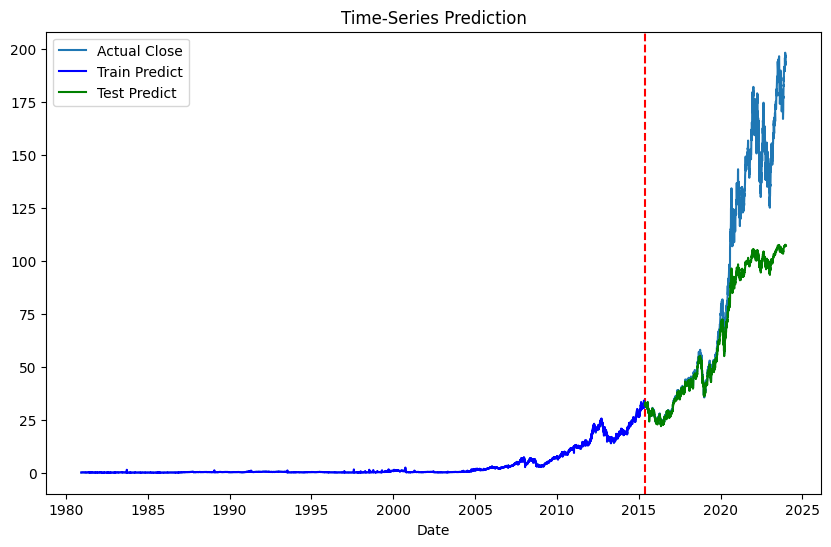

In [163]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
from torch.autograd import Variable
import pathlib

# Assuming get_latest_run_path, load_csv, prepare_data_2, and LSTM1 are defined elsewhere
# Assuming get_latest_run_path, load_csv, prepare_data_2, and LSTM1 are defined elsewhere
def teste_1():
    current_file_path = pathlib.Path().resolve()
    model_path = current_file_path / 'runs2' / 'train13' / 'model.pth'
    STOCKS_PATH = current_file_path / 'data/train_data.csv'
    dataset_4()
    df = load_csv(STOCKS_PATH)
    X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors = prepare_data_2(df, test_size=0.2)
    learning_rate = 0.01 #0.01 lr

    print(df.shape)
    input_size = 2 #number of features
    hidden_size = 2 #number of features in hidden state
    num_layers = 1 #number of stacked lstm layers

    num_classes = 1 #number of output classes 

    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:] 
    mm = MinMaxScaler()
    ss = StandardScaler()

    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y) 

    lstm1.load_state_dict(torch.load(model_path))

    df_X_ss = ss.transform(df.iloc[:, :-1]) #old transformers
    df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

    df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
    df_y_mm = Variable(torch.Tensor(df_y_mm))

    #reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

    train_predict = lstm1(df_X_ss) #forward pass
    data_predict = train_predict.data.numpy() #numpy conversion
    dataY_plot = df_y_mm.data.numpy()

    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)

    print(data_predict.shape)

    # Calculate the split index
    split_index = int(len(data_predict) * (1 - 0.2))

    # Split data_predict into train and test predictions
    train_predict_plot = data_predict[:split_index]
    test_predict_plot = data_predict[split_index:]

    # Extract the date column
    dates = df.index
    split_date = dates[split_index]

    # Forecasting beyond the dataset limits
    forecast_steps = 10  # Number of steps to forecast
    last_input = df_X_ss[-1].unsqueeze(0)  # Use the last input as the initial input

    lstm1.eval()

    # Plotting
    plt.figure(figsize=(10,6))

    plt.axvline(x=split_date, c='r', linestyle='--') # size of the training set

    plt.plot(dates, dataY_plot, label='Actual Close') # actual plot
    plt.plot(dates[:split_index], train_predict_plot, label='Train Predict', color='blue') # train predicted plot
    plt.plot(dates[split_index:], test_predict_plot, label='Test Predict', color='green') # test predicted plot


    plt.title('Time-Series Prediction')
    plt.yscale('linear')
    plt.xlabel('Date')
    plt.legend()
    plt.savefig(get_latest_run_path('2') / 'model.png')
    plt.show()



def teste_2():
    current_file_path = pathlib.Path().resolve()
    model_path = get_latest_run_path('2') / 'model.pth'
    STOCKS_PATH = current_file_path / 'data/train_data.csv'
    df = load_csv(STOCKS_PATH)
    batch_size = 16  # Define the batch size
    seq_length = 1  # Define the sequence length

    train_loader, test_loader = prepare_data_4(df, seq_length=seq_length, test_size=0.2, batch_size=batch_size)

    input_size = 2
    hidden_size = 2
    num_layers = 1
    num_classes = 1

    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length) #our lstm class

    lstm1.load_state_dict(torch.load(model_path))

    lstm1.eval()
    train_predict = []
    test_predict = []
    actual = []

    with torch.no_grad():
        for X_batch, y_batch in train_loader:
            X_batch = Variable(X_batch)
            y_batch = Variable(y_batch)
            outputs = lstm1(X_batch)
            train_predict.extend(outputs.data.numpy())
            actual.extend(y_batch.data.numpy())

        for X_batch, y_batch in test_loader:
            X_batch = Variable(X_batch)
            y_batch = Variable(y_batch)
            outputs = lstm1(X_batch)
            test_predict.extend(outputs.data.numpy())

    train_predict = np.array(train_predict)
    test_predict = np.array(test_predict)
    actual = np.array(actual)

    mm = MinMaxScaler()
    actual = mm.fit_transform(actual.reshape(-1, 1))
    train_predict = mm.inverse_transform(train_predict)
    test_predict = mm.inverse_transform(test_predict)

    # Calculate the split index
    split_index = len(train_predict)

    # Extract the date column
    dates = df.index
    split_date = dates[split_index]

    # Ensure the lengths match
    dates_test = dates[split_index:split_index + len(test_predict)]

    # Plotting
    plt.figure(figsize=(10,6))

    plt.axvline(x=split_date, c='r', linestyle='--') # size of the training set

    plt.plot(dates[:split_index], actual[:split_index], label='Actual Close') # actual plot
    plt.plot(dates[:split_index], train_predict, label='Train Predict', color='blue') # train predicted plot
    plt.plot(dates_test, test_predict, label='Test Predict', color='green') # test predicted plot

    plt.title('Time-Series Prediction')
    plt.yscale('linear')
    plt.xlabel('Date')
    plt.legend()
    plt.savefig(get_latest_run_path('2') / 'model.png')
    plt.show()


#Pipeline 2 com só uma coluna (Close)
def teste_3():
    current_file_path = pathlib.Path().resolve()
    model_path = get_latest_run_path('2') / 'model.pth'
    #model_path = current_file_path / 'runs2' / 'train13' / 'model.pth'
    STOCKS_PATH = current_file_path / 'data/train_data.csv'
    df = load_csv(STOCKS_PATH)
    X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors = prepare_data_205(df, test_size=0.2)
    learning_rate = 0.01 #0.01 lr

    print(df.shape)
    df = df[['Close']]
    input_size = 1 #number of features
    hidden_size = 2 #number of features in hidden state
    num_layers = 1 #number of stacked lstm layers

    num_classes = 1 #number of output classes 

    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

    X = df.iloc[:, -1:]
    y = df.iloc[:, -1:] 
    mm = MinMaxScaler()
    ss = StandardScaler()

    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y) 

    lstm1.load_state_dict(torch.load(model_path))

    df_X_ss = ss.transform(df.iloc[:, -1:]) #old transformers
    df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

    df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
    df_y_mm = Variable(torch.Tensor(df_y_mm))

    #reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

    train_predict = lstm1(df_X_ss) #forward pass
    data_predict = train_predict.data.numpy() #numpy conversion
    dataY_plot = df_y_mm.data.numpy()

    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)

    print(data_predict.shape)

    # Calculate the split index
    split_index = int(len(data_predict) * (1 - 0.2))

    # Split data_predict into train and test predictions
    train_predict_plot = data_predict[:split_index]
    test_predict_plot = data_predict[split_index:]

    # Extract the date column
    dates = df.index
    split_date = dates[split_index]

    # Forecasting beyond the dataset limits
    forecast_steps = 10  # Number of steps to forecast
    last_input = df_X_ss[-1].unsqueeze(0)  # Use the last input as the initial input

    lstm1.eval()
    forecast = []
    with torch.no_grad():
        for _ in range(forecast_steps):
            next_output = lstm1(last_input)
            print(f"next_output shape: {next_output.shape}")  # Debugging print statement
            forecast.append(next_output.cpu().numpy())
            last_input = next_output.unsqueeze(0)  # Use the output as the next input
            last_input = torch.reshape(last_input, (1, 1, input_size))  # Ensure the correct shape

    forecast = np.concatenate(forecast, axis=0)
    forecast = mm.inverse_transform(forecast)  # Reverse tran

    # Extend the dates for the forecast
    #forecast_dates = pd.date_range(start=dates[-1], periods=forecast_steps + 1, inclusive='right')
    # Plotting
    plt.figure(figsize=(10,6))

    plt.axvline(x=split_date, c='r', linestyle='--') # size of the training set

    plt.plot(dates, dataY_plot, label='Actual Close') # actual plot
    plt.plot(dates[:split_index], train_predict_plot, label='Train Predict', color='blue') # train predicted plot
    plt.plot(dates[split_index:], test_predict_plot, label='Test Predict', color='green') # test predicted plot
    #plt.plot(forecast_dates, forecast, label='Forecast', color='orange')  # forecast plot

    plt.title('Time-Series Prediction')
    plt.yscale('linear')
    plt.xlabel('Date')
    plt.legend()
    plt.savefig(get_latest_run_path('2') / 'model.png')
    plt.show()


#teste_3()
teste_1()

### Teste dasdsadas

[*********************100%%**********************]  1 of 1 completed

AAPL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10853 entries, 0 to 10852
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10853 non-null  datetime64[ns]
 1   Close   10853 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 169.7 KB
None
               Close
Date                
1980-12-12  0.128348
1980-12-15  0.121652
1980-12-16  0.112723
1980-12-17  0.115513
1980-12-18  0.118862
Current file path: D:\Github\Stocks-Machine-Learning\code3


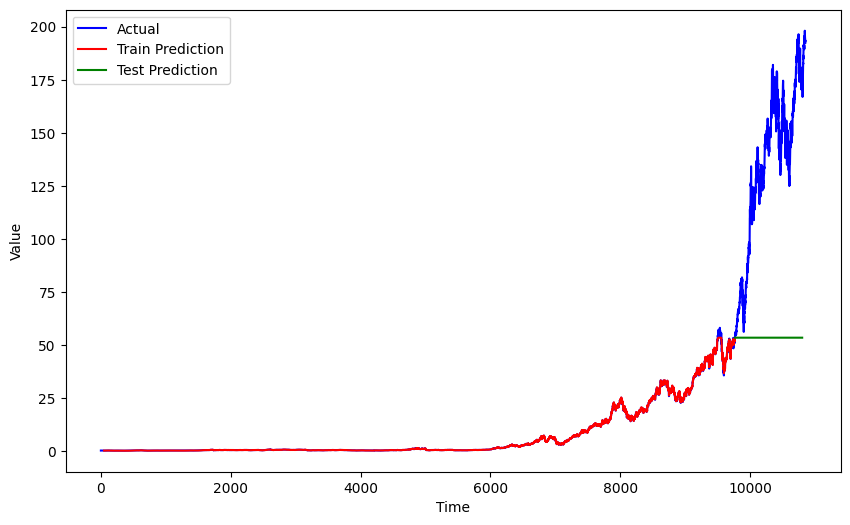

In [142]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def test_model_1(model_path, X_train, X_test, y_train, y_test, timeseries, lookback=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        # shift train predictions for plotting
        train_plot = np.ones_like(timeseries) * np.nan
        y_pred_train = model(X_train)[:, -1, :]
        train_plot[lookback:len(X_train) + lookback] = y_pred_train.cpu().numpy().flatten()

        # shift test predictions for plotting
        test_plot = np.ones_like(timeseries) * np.nan
        y_pred_test = model(X_test)[:, -1, :]
        test_plot[len(X_train) + lookback:len(X_train) + lookback + len(X_test)] = y_pred_test.cpu().numpy().flatten()

        y_pred = model(X_test).cpu().numpy()
        y_test_np = y_test.cpu().numpy()
    '''    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
        mae = mean_absolute_error(y_test_np, y_pred)
        r2 = r2_score(y_test_np, y_pred)

    test_metrics = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")

    TEST_METRIC_PATH = get_latest_run_path() / 'test_metrics.json'
    with open(TEST_METRIC_PATH, 'w') as f:
        json.dump(test_metrics, f)
    print(f"Test metrics saved to {TEST_METRIC_PATH}")'''

    # plot
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, c='b', label='Actual')
    plt.plot(train_plot, c='r', label='Train Prediction')
    plt.plot(test_plot, c='g', label='Test Prediction')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig(get_latest_run_path() / 'model.png')
    plt.show()

current_file_path = pathlib.Path().resolve()
# Save the DataFrame to a CSV file in the same directory
STOCKS_PATH = current_file_path / 'data/train_data.csv'
CURRENT_MODEL_PATH = get_latest_run_path() / 'model.pth'

#Download/tratamento dos dos dados
dataset_1()

#Transformação dos dados
df = load_csv(STOCKS_PATH)
df = df['Close']
X_train, y_train, X_test, y_test = prepare_data_1(df, lookback=50, test_size=0.1)
# Run the training pipeline

# Pass the full timeseries data for plotting
timeseries = df.values

# Run the test model function
test_model_1(CURRENT_MODEL_PATH, X_train, X_test, y_train, y_test, timeseries)
